In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
v1=json.load(open('../../mc1_vis_system/public/MC1.json'))
nodes_df=pd.DataFrame(v1['nodes'])
links_df=pd.DataFrame(v1['links'])

In [5]:
nodes_df.head()

,type,dataset,country,id
0,company,MC1,Nalakond,Spanish Shrimp Carriers
1,organization,MC1,NaN,12744
2,organization,MC1,NaN,143129355
3,organization,MC1,NaN,7775
4,organization,MC1,NaN,1017141


In [6]:
nodes_df['type'].fillna('unknown',inplace=True)

In [7]:
links_df['type'].fillna('unknown',inplace=True)
link_types=links_df['type'].unique()
link_types

array(['ownership', 'partnership', 'family_relationship', 'membership'],
      dtype=object)

In [8]:
# 邻居类型分布、邻居之间边的类型分布、入度出度+直连边类型
type_groups=list(nodes_df.groupby('type'))
# type_groups[0][0]
# 最后一个也是一个key
for i in type_groups[0][1]['id']:
    print(i)
    break
types=[_[0] for _ in type_groups]
print(types)


Spanish Shrimp  Carriers
['company', 'event', 'location', 'movement', 'organization', 'person', 'political_organization', 'unknown', 'vessel']


In [9]:
one_level_neighbour={}
# 出边邻居
out_links=list(links_df.groupby('source'))
for i in out_links:
    src,src_df=i
    if src not in one_level_neighbour:
        one_level_neighbour[src]=[]
    for j in src_df['target']:
        if j not in one_level_neighbour[src]:
            one_level_neighbour[src].append(j)

# 入边邻居
in_links=list(links_df.groupby('target'))
for i in in_links:
    tgt,tgt_df=i
    if tgt not in one_level_neighbour:
        one_level_neighbour[tgt]=[]
    for j in tgt_df['source']:
        # if j==90:
        #     print(1)
        if j not in one_level_neighbour[tgt]:
            one_level_neighbour[tgt].append(j)
print(one_level_neighbour['dup90'],'\n',one_level_neighbour["90"])


['days', 'Benton Ltd. Liability Co', 'sh rn y Corporation', '43685541', 'ad8fe467-3759-4f53-bf6a-896a237d187f', 'Playa del Cielo Kga', '979893388', '2913', 'ninety', '822596165', '5421', 'Pez Dorado BV Logistics', '019d89a8-36be-4402-bf3c-d13cb982cf3f', '6f59e8d7-8f5d-4a7d-a3a4-50ddcb7ad9ad'] 
 ['884648', 'Â£800', 'Sara Waller', '341411', '750975']


In [10]:
two_level_neighbour={}
for i in one_level_neighbour:
    if i not in two_level_neighbour:
        two_level_neighbour[i]=[]
    # for j in one_level_neighbour[i]:
        # 一阶邻居的邻居
        # 出边邻居
        # out_links=list(links_df.groupby('source'))
    for ol in out_links:
        src,src_df=ol
        if src in one_level_neighbour[i]:
            for one_nei_tgt in src_df['target']:
                if one_nei_tgt not in two_level_neighbour[i] and (one_nei_tgt not in one_level_neighbour[i]):
                    two_level_neighbour[i].append(one_nei_tgt)
    # 入边邻居
    # in_links=list(links_df.groupby('target'))
    for il in in_links:
        tgt,tgt_df=il
        if tgt in one_level_neighbour[i]:
            for one_nei_src in tgt_df['source']:
                if one_nei_src not in two_level_neighbour[i] and (one_nei_src not in one_level_neighbour[i]):
                    two_level_neighbour[i].append(one_nei_src)
two_level_neighbour['dup90']
            

['dup90',
 '903311212',
 'Diao er Ltd. Corporation Transport',
 '102642',
 '7691',
 'DOFâ\x80\x99s',
 'John Barnes DDS',
 '3887',
 'Amanda Contreras',
 'Susan Hodges',
 'â\x80\x9cWe fins',
 'Jerry Welch',
 'Joanna Brown',
 'â\x80\x9cHe',
 'Jamie Robinson',
 '46319064',
 '46901627',
 'Amanda Mckenzie',
 'Mar del Oeste Pic',
 'b840c9bf-2a5b-416c-91d9-1ecdd96425ab',
 '4eddaaa4-6306-467e-a7f4-27a58559e535',
 '81',
 'SeaSpray Wave SRL Solutions',
 'Oceanfront Oasis Inc Carriers',
 'months',
 'Sept',
 'John Gonzalez',
 'Amy Wise',
 '34',
 '98703',
 'Dana Goodwin',
 '567',
 '990',
 '23',
 'Jennifer Reilly',
 'Kristin Jones',
 'Krystal Lee',
 'ARA Contraalmirante Cordero',
 'Irish Sea SRL Brothers',
 'Romero Oyster NV Carriers',
 'Sea Harvest',
 'â\x80\x9cBHFâ',
 'Madhya Pradesh Market BV',
 'usa',
 '4',
 '418382',
 '16927047',
 '30041',
 '6471708',
 '520673',
 '565431',
 'Ryabikova',
 'Erica Hamilton',
 'Michael Reed',
 'Andrea Gibson',
 'Kelsey Tucker',
 'Ryan Lewis',
 'Jessica Figueroa DDS'

In [11]:
# 每个type是个tuple，第一个元素是type的名字，第二个元素是一个dataframe
# 每一个type的每一个节点的邻居类型分布的平均值：
# 除去异常节点
anomalies=["Mar de la Vida OJSC" , 979893388 , "Oceanfront Oasis Inc Carriers" , 8327]
all_types_neighbor_one=[]
all_types_neighbor_two=[]
for i in type_groups:
    type_name, type_df=i
    type_df=type_df[~type_df['id'].isin(anomalies)]
    type_tot_num=type_df.shape[0]
    neighbor_type_one={}
    neighbor_type_two={}
    # 初始化字典存每个id对应的邻居列表
    for each_type in types:
        neighbor_type_one[each_type]=0
        neighbor_type_two[each_type]=0
    # 对这个类型里每个node找一阶邻居
    for node in type_df['id']:
        for nei in one_level_neighbour[node]:
            nei_type=nodes_df[nodes_df['id']==nei]['type'].values[0]
            neighbor_type_one[nei_type]+=1
        for two_nei in two_level_neighbour[node]:
            two_nei_type=nodes_df[nodes_df['id']==two_nei]['type'].values[0]
            neighbor_type_two[two_nei_type]+=1

    # 出来统计完
    for each_type in neighbor_type_one:
        neighbor_type_one[each_type]/=type_tot_num
    for each_type in neighbor_type_two:
        neighbor_type_two[two_nei_type]/=type_tot_num
    print(type_tot_num)
    all_types_neighbor_one.append(neighbor_type_one)
    all_types_neighbor_two.append(neighbor_type_two)
all_types_neighbor_one[0]
    

90
74
393
21
987
1022
121
603
115


{'company': 0.7333333333333333,
 'event': 0.28888888888888886,
 'location': 1.7,
 'movement': 0.18888888888888888,
 'organization': 4.666666666666667,
 'person': 3.1,
 'political_organization': 0.3333333333333333,
 'unknown': 2.577777777777778,
 'vessel': 0.36666666666666664}

### 一阶的情况：邻居类型分布

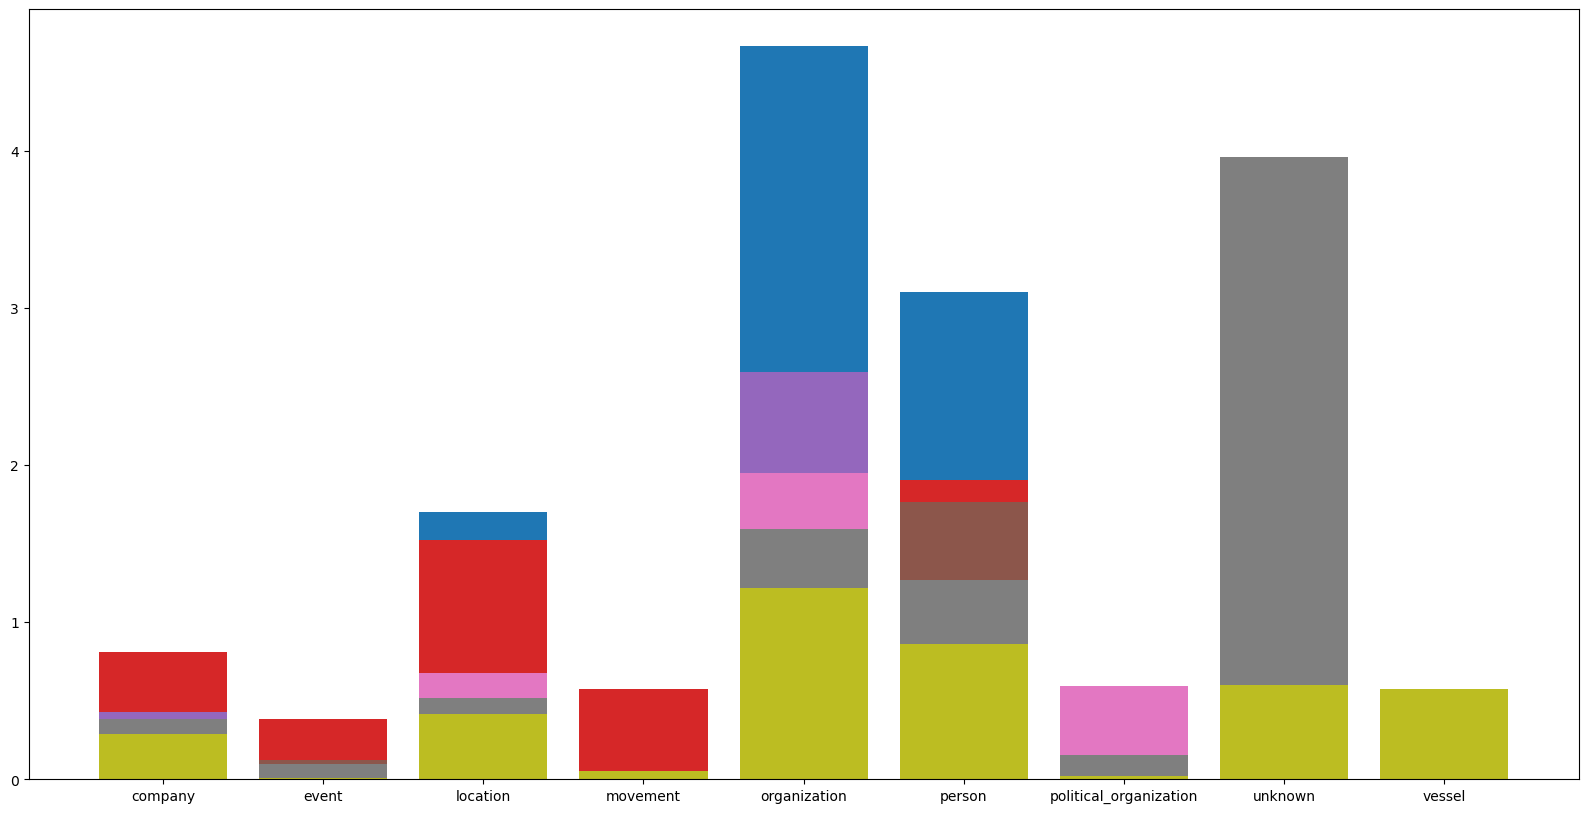

In [12]:
plt.figure(figsize=(20,10))
for each_type_nei in all_types_neighbor_one:
    plt.bar(each_type_nei.keys(),each_type_nei.values())


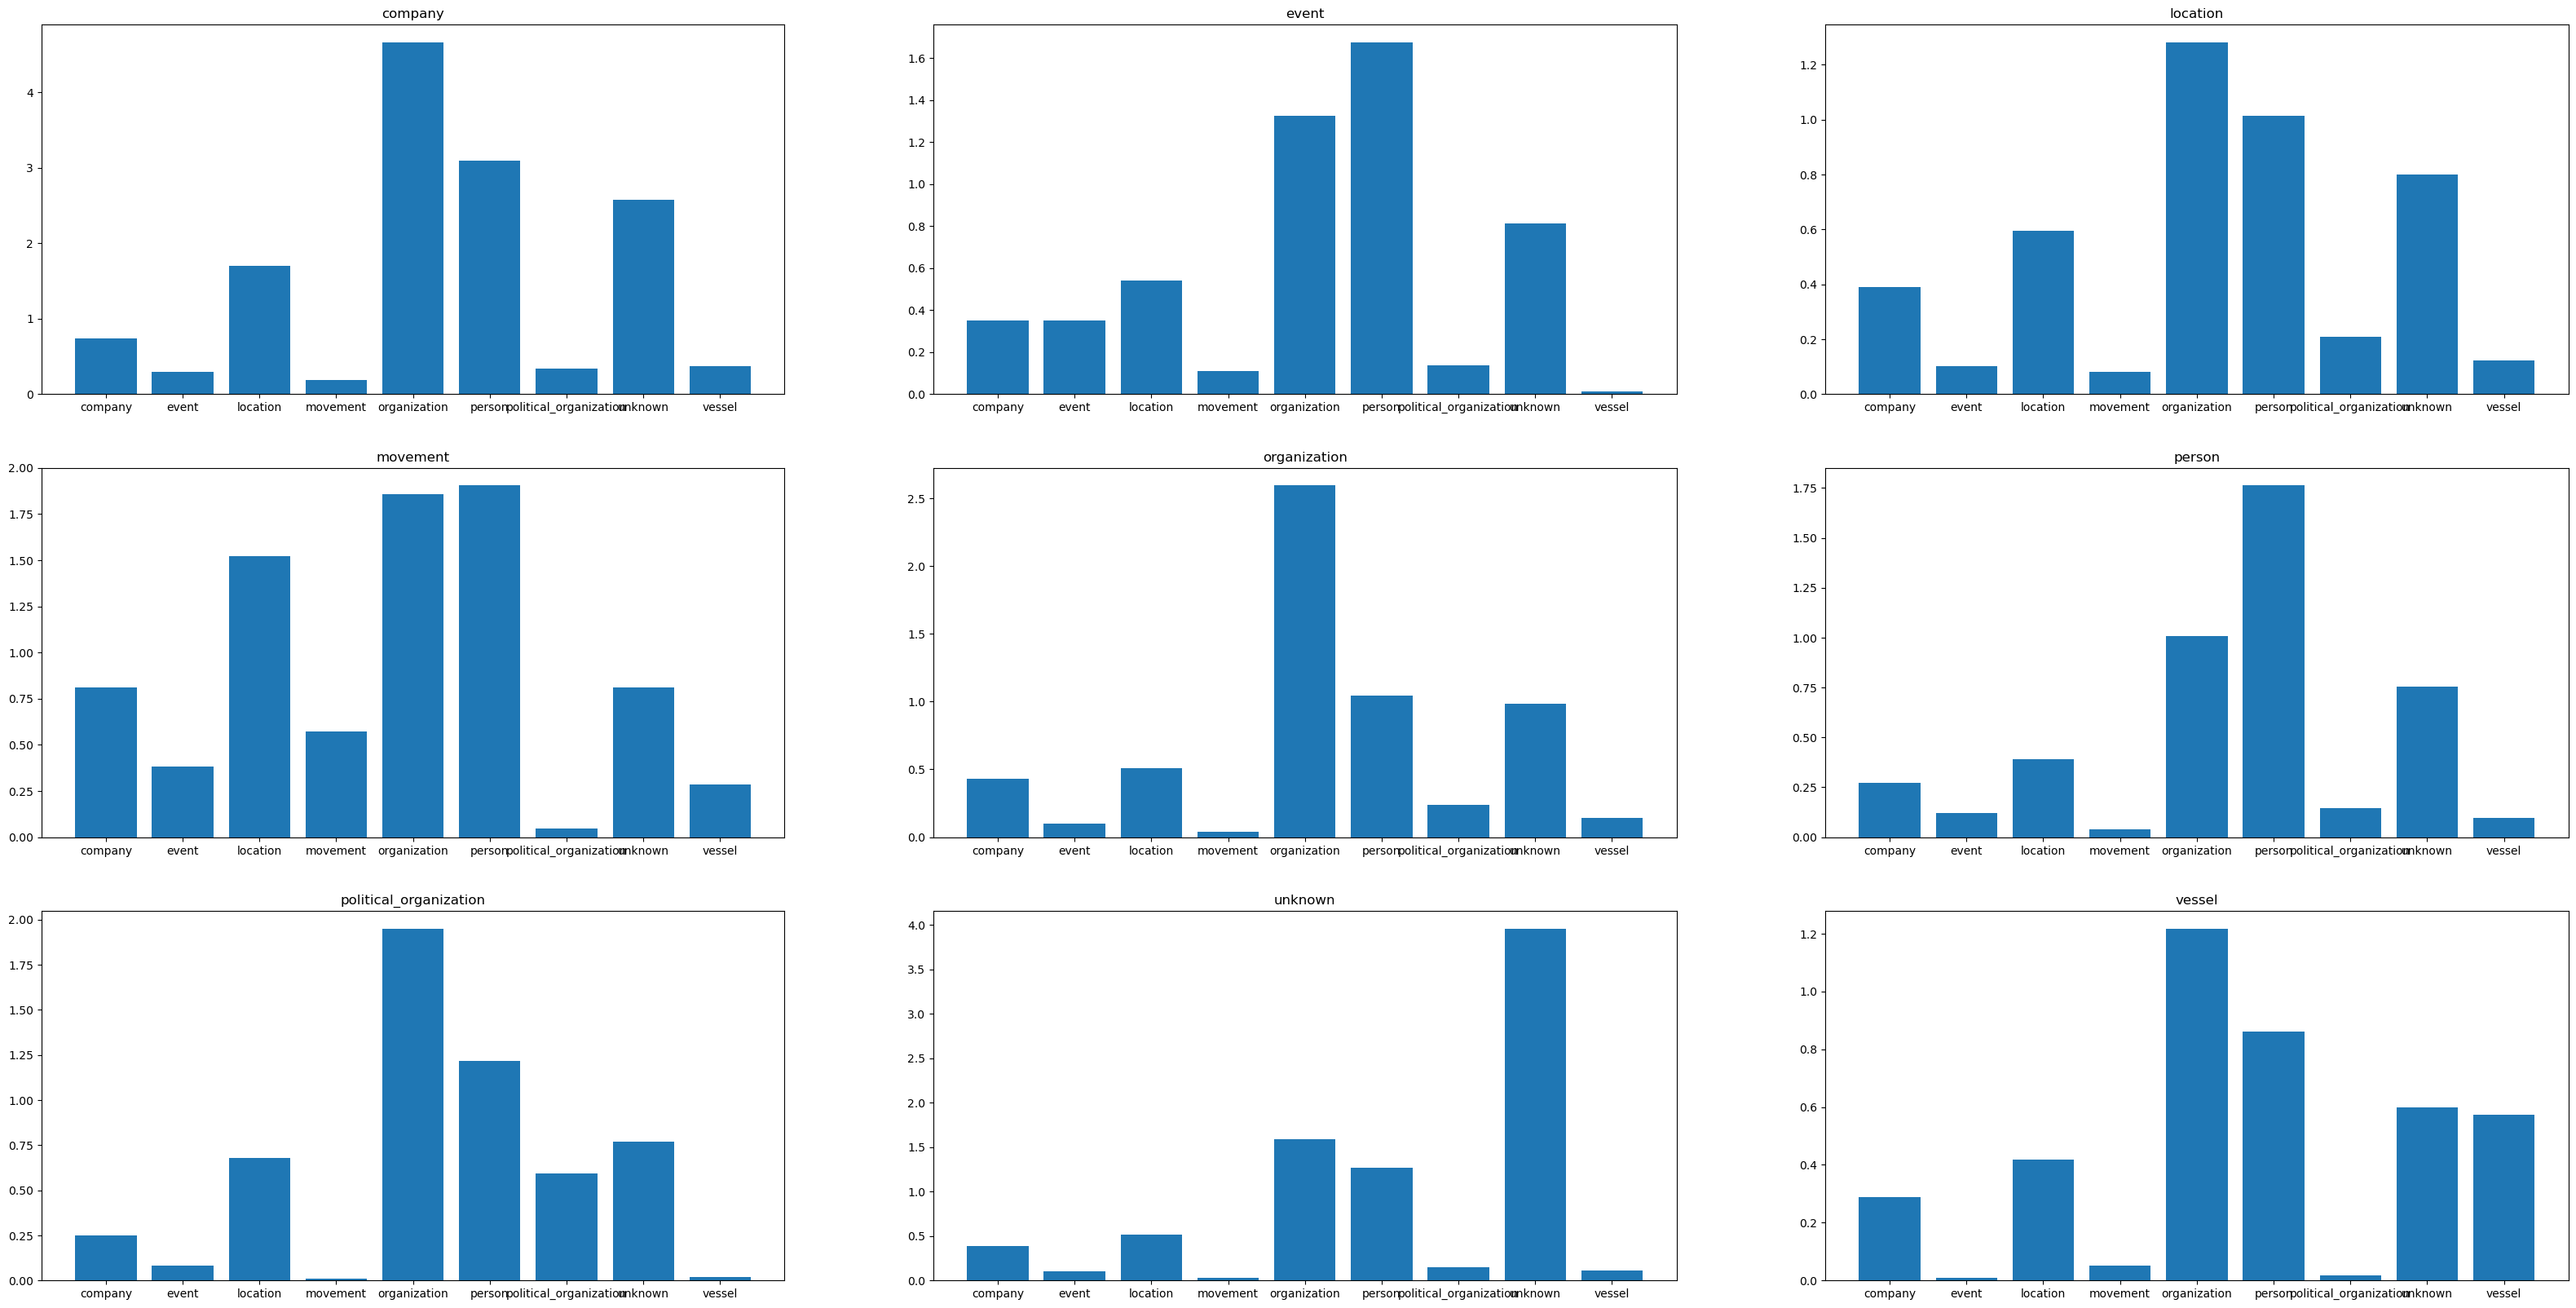

In [13]:
plt.figure(figsize=(40,20))
for idx,each_type_nei in enumerate(all_types_neighbor_one):
    plt.subplot(3,3,idx+1)
    plt.bar(each_type_nei.keys(),each_type_nei.values())
    plt.title(types[idx])
    # plt.legend()

### 二阶的情况：邻居类型分布

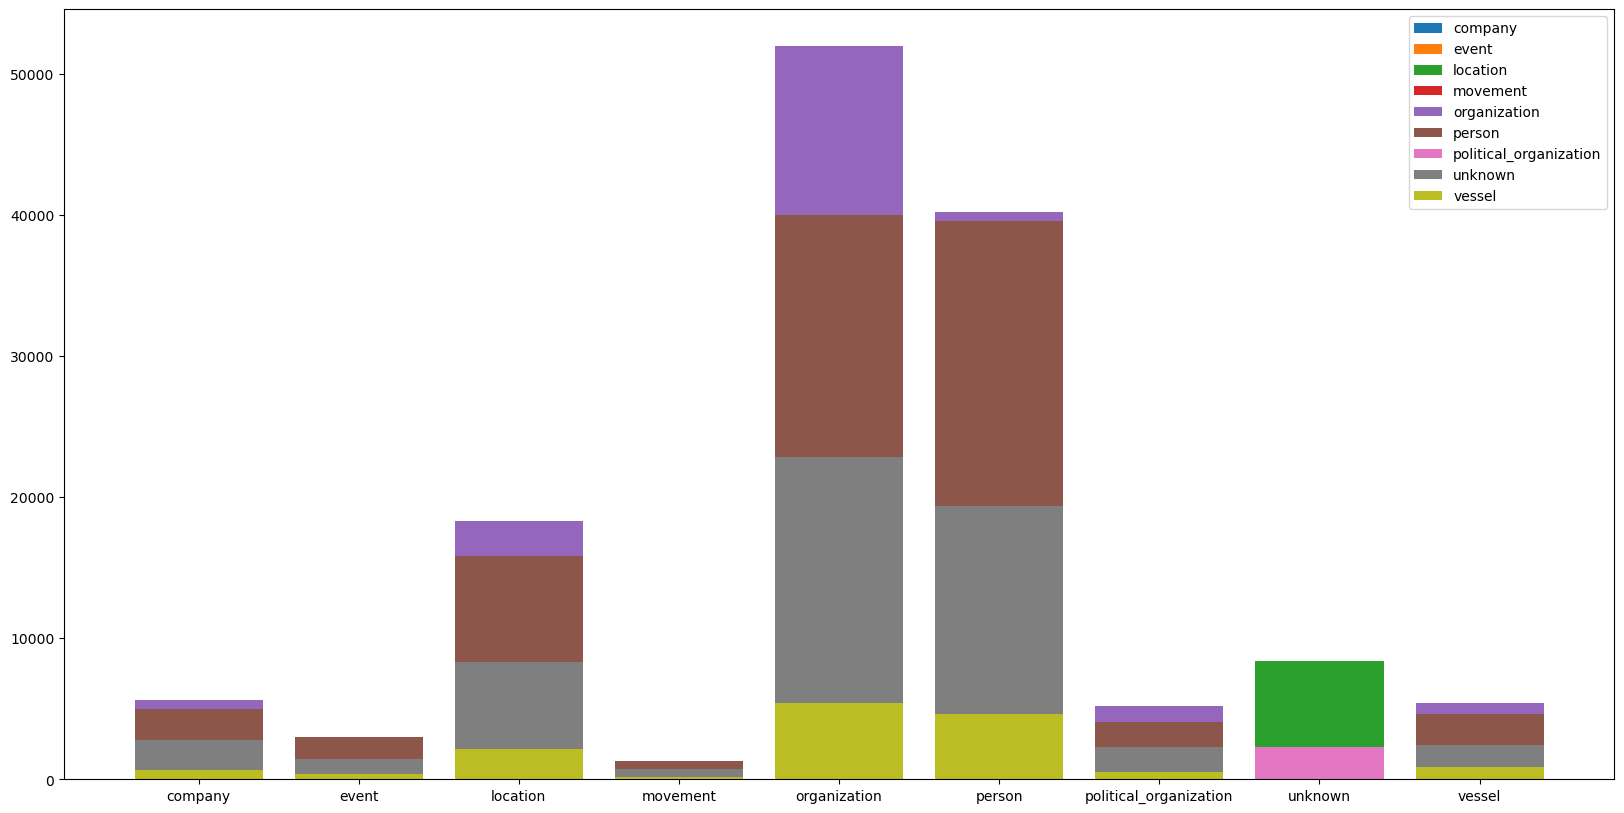

In [14]:
plt.figure(figsize=(20,10))
for idx,each_two_nei in enumerate(all_types_neighbor_two):
    plt.bar(each_two_nei.keys(),each_two_nei.values(),label=types[idx])
    plt.legend()

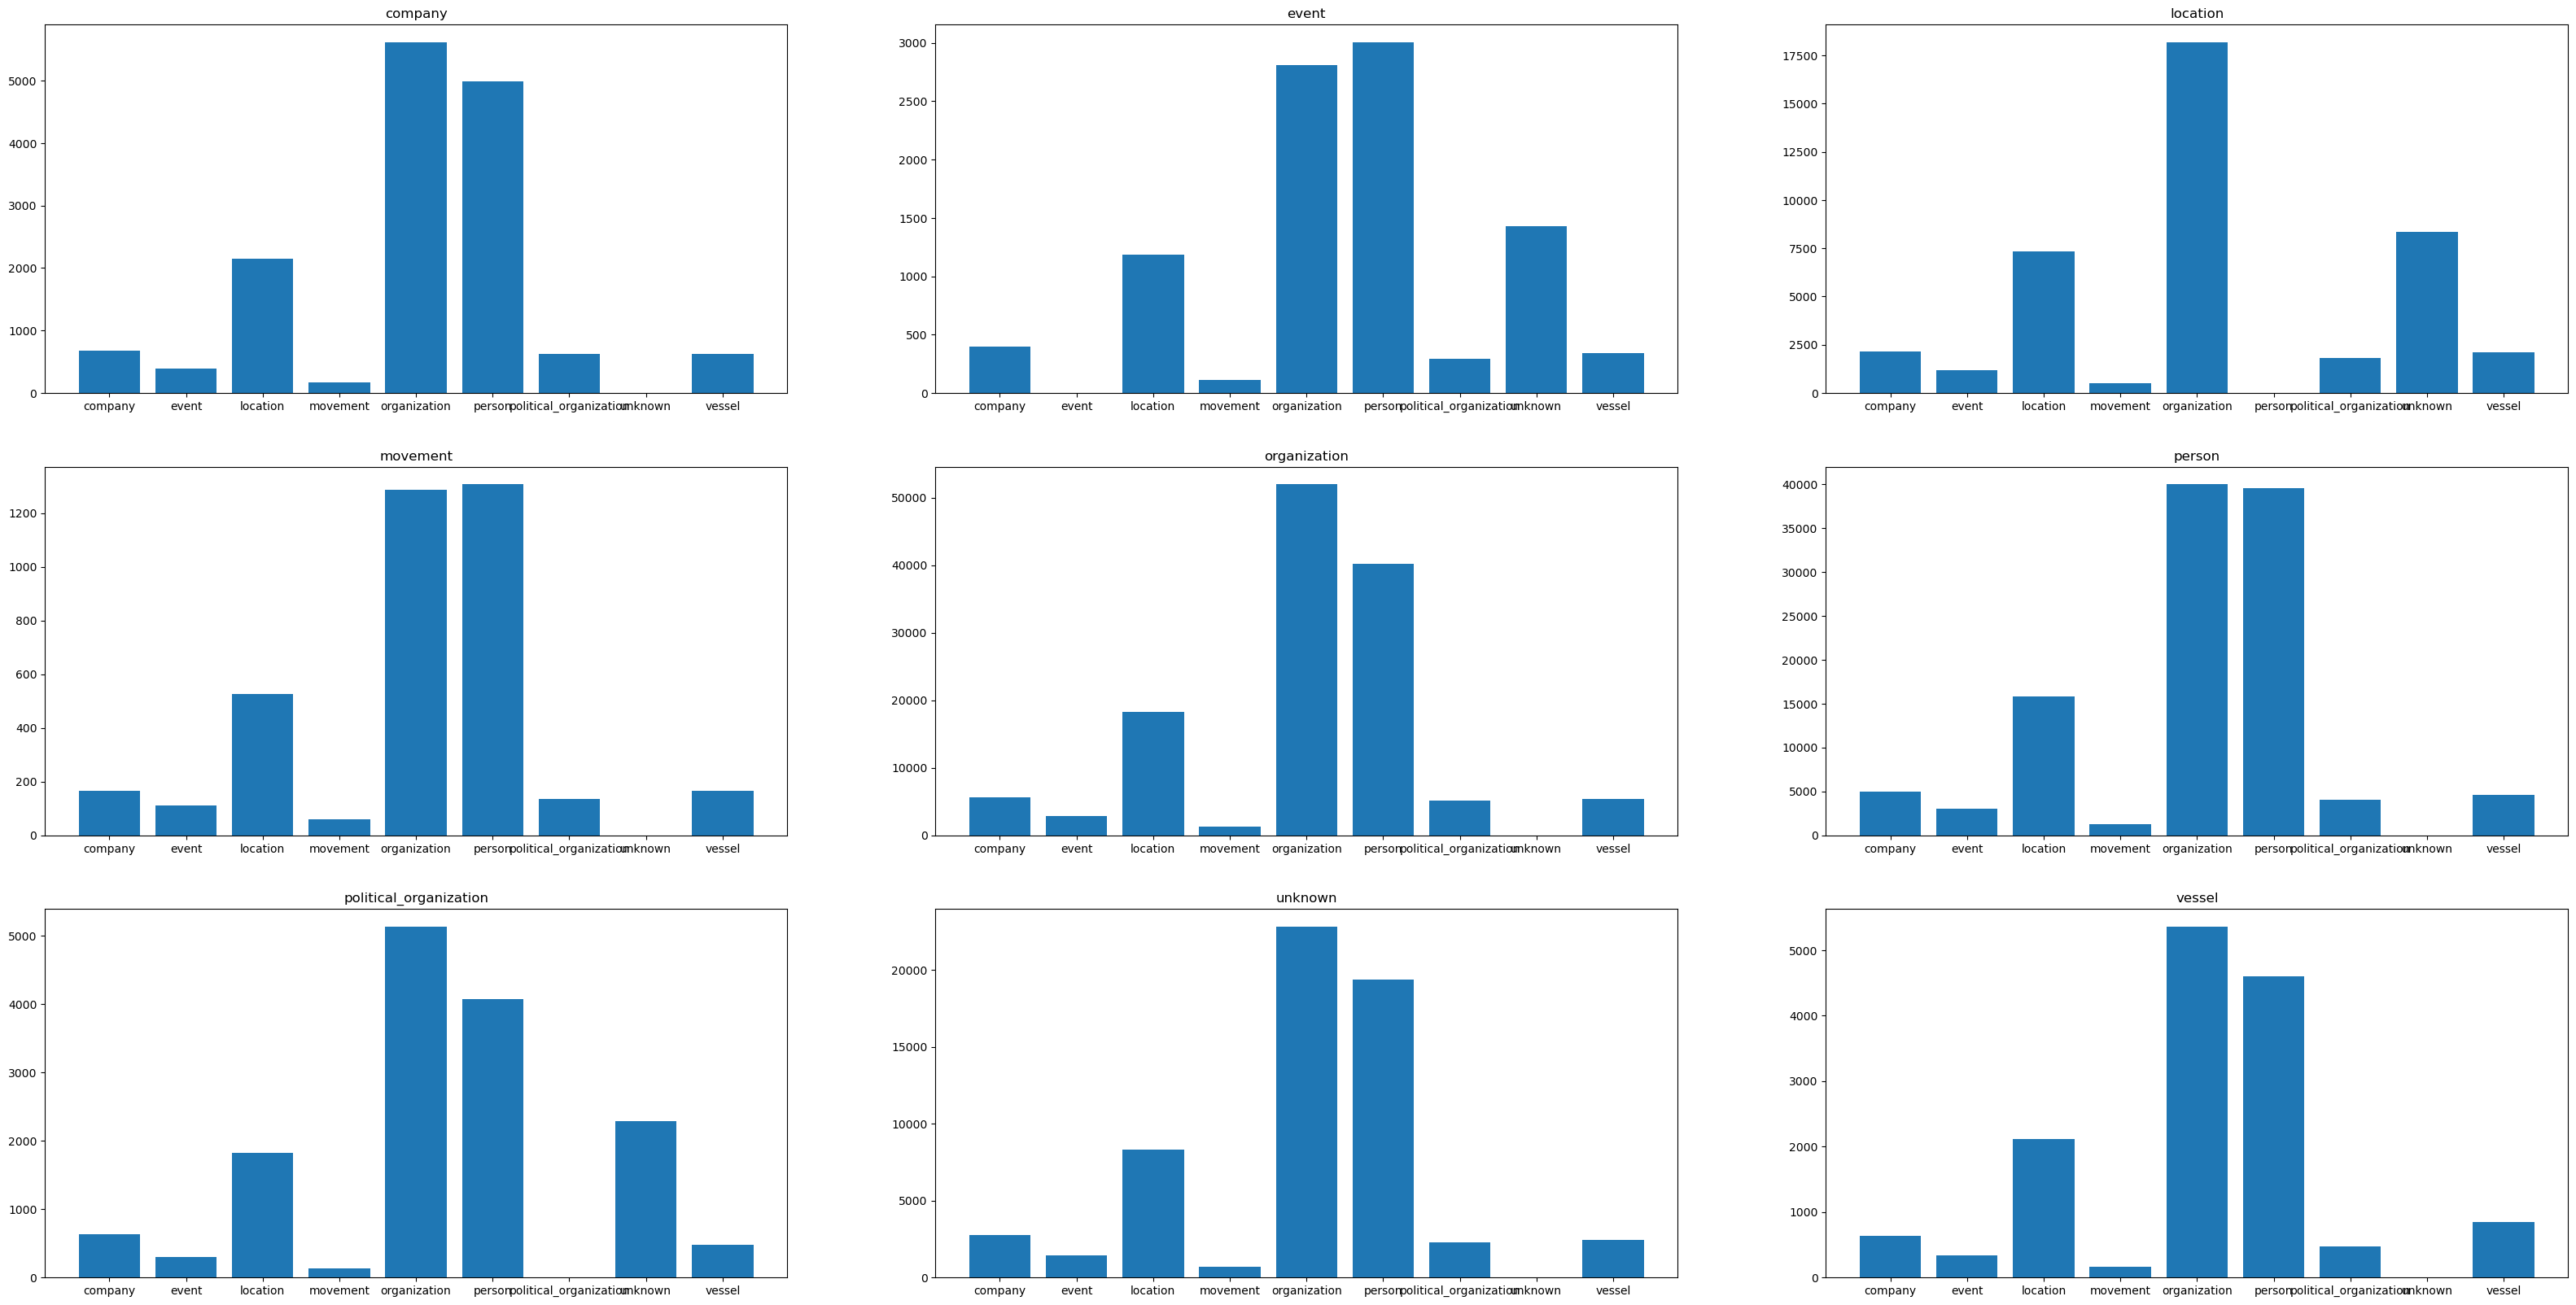

In [15]:
plt.figure(figsize=(40,20))
for idx,each_two_nei in enumerate(all_types_neighbor_two):
    plt.subplot(3,3,idx+1)
    plt.bar(each_two_nei.keys(),each_two_nei.values())
    plt.title(types[idx])

### 邻居之间边的类型分布

In [16]:
aaa=links_df[links_df['source']=="dup90"]['type'].value_counts()
aaa=dict(aaa)
for i in aaa:
    print(i,aaa[i])
# print(links_df[links_df['source']=="90"].shape[0])

partnership 3
membership 2
ownership 1


### 入度出度+直连边类型

In [17]:
# 每个类型对应一个tuple：(入度，出度)
deg_sta=[]
all_dir_link_type=[]
for i in type_groups:
    type_name, type_df=i
    type_df=type_df[~type_df['id'].isin(anomalies)]
    type_tot_num=type_df.shape[0]
    dir_link_type={}
    # 字典 每个直连边类型的数量
    for each_link_type in link_types:
        dir_link_type[each_link_type]=0
    in_deg,out_deg=0,0
    for node in type_df['id']:
        in_deg+=links_df[links_df['target']==node].shape[0]
        out_deg+=links_df[links_df['source']==node].shape[0]
        dir_link_type_each=dict(links_df[links_df['source']==node]['type'].value_counts())
        for each_exist_type in dir_link_type_each:
            dir_link_type[each_exist_type]+=dir_link_type_each[each_exist_type]
    # 类型平均每个节点出入度
    in_deg/=type_tot_num
    out_deg/=type_tot_num
    deg_sta.append((in_deg,out_deg))
    # 类型平均每个节点直连边类型
    for each in dir_link_type:
        dir_link_type[each]/=type_tot_num
    all_dir_link_type.append(dir_link_type)




[8.6, 3.472972972972973, 2.0229007633587788, 4.857142857142857, 3.072948328267477, 2.713307240704501, 2.4628099173553717, 4.598673300165838, 2.252173913043478]


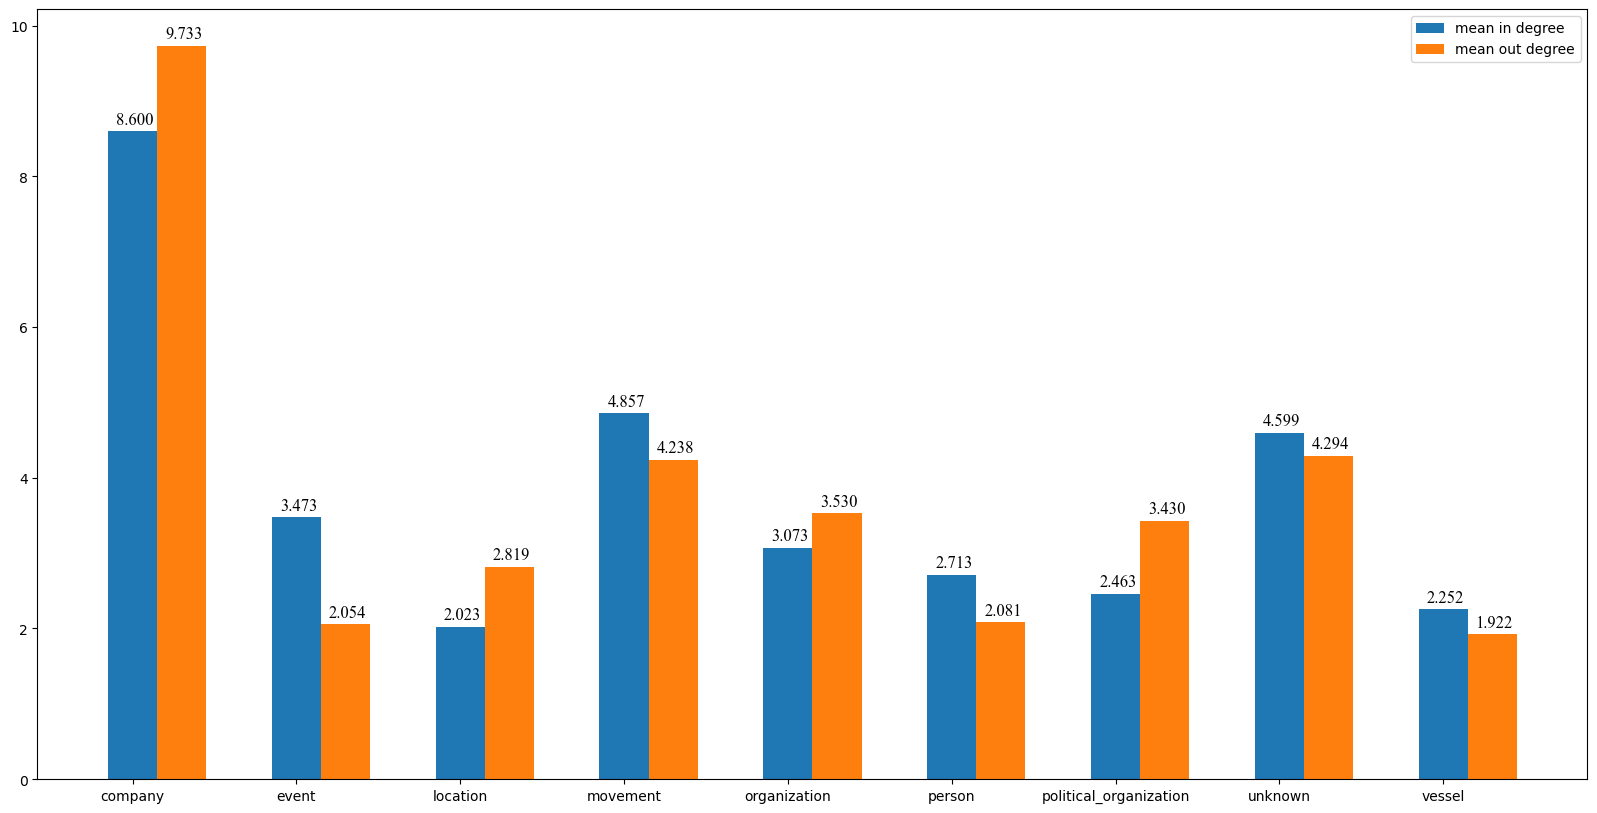

In [18]:
# 出入度画在一张图里
all_type_in=[_[0] for _ in deg_sta]
all_type_out=[_[1] for _ in deg_sta]
print(all_type_in)
plt.figure(figsize=(20,10))
# x: types
in_pos=range(len(types)) #通常将x轴上的数字数字化处理
out_pos=[i+0.3 for i in in_pos] #设置间隔，因为是两个产品，所以第二个产品应该在第一个条形图往右移动一格
plt.bar(in_pos,all_type_in,width=0.3,label="mean in degree")#设置图例
plt.bar(out_pos,all_type_out,width=0.3,label="mean out degree")
plt.xticks(range(len(types)),types)#设置x轴的刻度说明
for idx,height in enumerate(all_type_in):
    plt.text(in_pos[idx]-0.1,height+0.1,'%.3f'%height, size=12, family="Times new roman")
for idx,height in enumerate(all_type_out):
    plt.text(out_pos[idx]-0.1,height+0.1,'%.3f'%height, size=12, family="Times new roman")
plt.legend() #显示图例
plt.show()


{'ownership': [2.3, 0.5, 0.5776081424936387, 1.619047619047619, 0.7152988855116514, 0.24951076320939333, 0.7851239669421488, 0.603648424543947, 0.48695652173913045], 'partnership': [2.1444444444444444, 0.40540540540540543, 0.5954198473282443, 0.8095238095238095, 0.9918946301925026, 0.33268101761252444, 0.7024793388429752, 1.6185737976782753, 0.5391304347826087], 'family_relationship': [1.6222222222222222, 0.22972972972972974, 0.39185750636132316, 0.5238095238095238, 0.585612968591692, 1.0293542074363993, 0.4462809917355372, 0.5854063018242123, 0.25217391304347825], 'membership': [3.6666666666666665, 0.918918918918919, 1.2544529262086515, 1.2857142857142858, 1.237082066869301, 0.46966731898238745, 1.4958677685950412, 1.4859038142620231, 0.6434782608695652]}
partnership ownership
family_relationship partnership
membership family_relationship


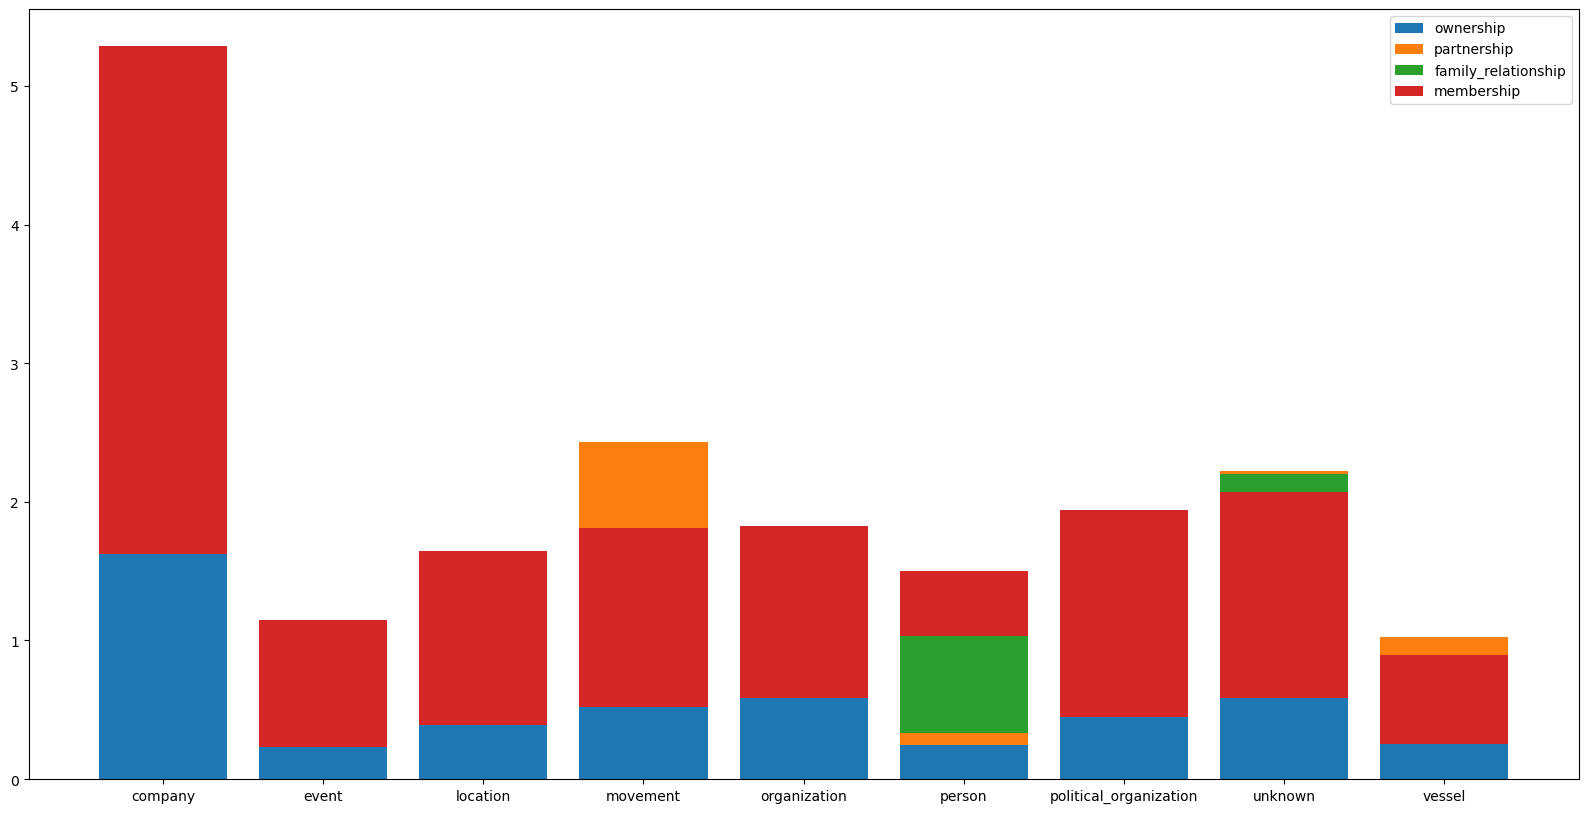

In [20]:
plt.figure(figsize=(20,10))
piled_link={}
for each_link_type in link_types:
    piled_link[each_link_type]=[]
for each_node_type in all_dir_link_type:
    # print(each_node_type)
    for each_link_type in each_node_type:
        piled_link[each_link_type].append(each_node_type[each_link_type])
print(piled_link)
idx_links=[i for i in piled_link]
for idx,each_link in enumerate(piled_link):
    # print(each_link)
    
    if idx>0:
        plt.bar(types,piled_link[each_link],label=each_link,bottom=piled_link[idx_links[idx-1]])
        print(each_link,idx_links[idx-1])
    else: 
        plt.bar(types,piled_link[each_link],label=each_link)
    plt.legend()